In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import tensorflow as tf
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers

In [2]:
dir_path = '/home/liaoqing/program data/kaggle race/riiid-data/'
file_train = 'train.csv'
file_questions = 'questions.csv'
file_lectures = 'lectures.csv'

In [3]:
nrows = 100 * 10000
#nrows = None
train = pd.read_csv(
                    dir_path + file_train, 
                    nrows=nrows, 
                    usecols=['row_id', 'timestamp', 'user_id', 'content_id', 
                             'content_type_id', 'task_container_id', 'answered_correctly',
                            'prior_question_elapsed_time','prior_question_had_explanation'],
                    dtype={
                            'row_id': 'int64',
                            'timestamp': 'int64',
                            'user_id': 'int32',
                            'content_id': 'int16',
                            'content_type_id': 'int8',
                            'task_container_id': 'int8',
                            'answered_correctly': 'int8',
                            'prior_question_elapsed_time': 'float32',
                            'prior_question_had_explanation': 'str'
                        }
                   )

In [4]:
questions = pd.read_csv(
                        dir_path + file_questions, 
                        nrows=nrows,
                        usecols=['question_id','bundle_id','part'], 
                        dtype={
                           'question_id': 'int16',
                           'bundle_id': 'int16',
                           'part': 'int8',
                       }
                    )

In [5]:
train.head(10)

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,0,0,115,5692,0,1,1,NaN,NaN
1,1,56943,115,5716,0,2,1,37000.0,False
2,2,118363,115,128,0,0,1,55000.0,False
3,3,131167,115,7860,0,3,1,19000.0,False
4,4,137965,115,7922,0,4,1,11000.0,False
5,5,157063,115,156,0,5,1,5000.0,False
6,6,176092,115,51,0,6,1,17000.0,False
7,7,194190,115,50,0,7,1,17000.0,False
8,8,212463,115,7896,0,8,1,16000.0,False
9,9,230983,115,7863,0,9,1,16000.0,False


In [6]:
train['prior_question_had_explanation'] = train['prior_question_had_explanation'].map({'True':1,'False':0}).fillna(-1).astype(np.int8)
#map 改为1，0 fillna为-1 设置类型 astype np.int8

In [7]:
train = train[train['content_type_id']==0]
max_num = 100
train = train.groupby(['user_id']).tail(max_num)#取每个user最后100行的数据减小内存

In [8]:
train = pd.merge(left=train,
                 right=questions,
                 how='left',
                 left_on='content_id',
                 right_on='question_id'
                 )#左面训练数据右问题数据，左面全保留 左侧的con——id和右侧的ques_id对应合并

In [9]:
train.head(10)

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,question_id,bundle_id,part
0,0,0,115,5692,0,1,1,NaN,-1,5692,5692,5
1,1,56943,115,5716,0,2,1,37000.0,0,5716,5716,5
2,2,118363,115,128,0,0,1,55000.0,0,128,128,1
3,3,131167,115,7860,0,3,1,19000.0,0,7860,7860,1
4,4,137965,115,7922,0,4,1,11000.0,0,7922,7922,1
5,5,157063,115,156,0,5,1,5000.0,0,156,156,1
6,6,176092,115,51,0,6,1,17000.0,0,51,51,1
7,7,194190,115,50,0,7,1,17000.0,0,50,50,1
8,8,212463,115,7896,0,8,1,16000.0,0,7896,7896,1
9,9,230983,115,7863,0,9,1,16000.0,0,7863,7863,1


In [10]:
train = train.fillna(0)

处理类别特征 首先需要对特征进行编码 nan是0了编码从1开始 one hot太稀疏费内存类别多的话 若某一列[‘男’,'女','男','男','中'] -->先fit -->{‘男’：1，‘女’：2，‘中’:3}得到这么一个字典 -->tranform--> [1,2,1,1,3]

In [11]:
class cat_deal:
    def __init__(self):
        self.max_len = 0#不同个数 0是nan嘛所以从1开始算
        self.dict_map = {}
    
    def fit(self,cat_list):#做一个字典把输入list每有一个的值作为索引给一个从1开始的value
        index = 1
        for cat_i in cat_list:
            if cat_i not in self.dict_map:
                self.dict_map[cat_i]  = index
                index += 1
        self.max_len = index + 1#保险一点怕有异常值
    
    def transform (self,cat_list):#遍历返回一个list是用字典编好的
        cat_transform_list = []
        for cat_i in cat_list:
            if cat_i in self.dict_map:
                cat_transform_list.append(self.dict_map[cat_i])
            else:
                cat_transform_list.append(0)
        return cat_transform_list


处理浮点特征 用最大最小值做一个归一化

In [12]:
class float_deal:
    def __init__(self):
        self.min = 0
        self.max = 0
        self.max_min = 0
    
    def fit(self,float_list):#计算list里最大最小值
        for float_i in float_list:
            if float_i < self.min:
                self.min = float_i
            if float_i > self.max:
                self.max = float_i
        self.max_min = self.max - self.min
    
    def transform(self,float_list):#异常分别为0，1其余归一化
        float_transform_list = []
        for float_i in float_list:
            if float_i < self.min:
                float_transform_list.append(0)
            elif float_i > self.max:
                float_transform_list.append(1)
            else:
                float_transform_list.append(float_i/self.max_min)
        return float_transform_list

In [13]:
dict_cat_class = {}
for columns in ['user_id','content_id',\
                'task_container_id','prior_question_had_explanation',\
                'bundle_id','part']:
    dict_cat_class[columns] = cat_deal()
    dict_cat_class[columns].fit(train[columns])
    
    train[columns] = dict_cat_class[columns].transform(train[columns])
    print(columns)

user_id
content_id
task_container_id
prior_question_had_explanation
bundle_id
part


In [14]:
dict_float_class = {}
for columns in ['timestamp','prior_question_elapsed_time']:
    dict_float_class[columns] = float_deal()
    dict_float_class[columns].fit(train[columns])
    
    train[columns] = dict_float_class[columns].transform(train[columns])
    print(columns)

timestamp
prior_question_elapsed_time


<AxesSubplot:>

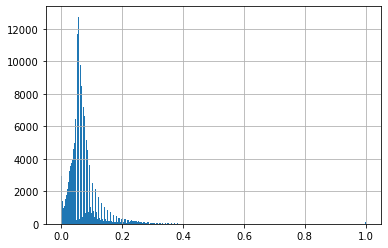

In [15]:
train['prior_question_elapsed_time'].hist(bins = 500)#看下分布 这样归一化样本分布部太平均的 0算是异常值吗这个要自己判断

包装一些可能用到的函数 包装成lambda 't' is a tensor of shape [1, 2, 1, 3, 1, 1] tf.shape(tf.squeeze(t, [2, 4])) # [1, 2, 3, 1]



In [16]:
def squeeze(embedding):#删除为1的维
    embedding = tf.squeeze(embedding,axis=1)
    return embedding
def concat(embedding_list):#沿第一维拼接张量
    embedding = tf.concat(embedding_list, axis=1)
    return embedding
def multiply(multi_x_y):#对应元素相乘
    multi_x = multi_x_y[0]
    multi_y = multi_x_y[1]
    multi_x_y = tf.multiply(multi_x, multi_y)
    return multi_x_y

In [17]:
input_timestamp = tf.keras.Input(shape=(1,))
input_prior_question_elapsed_time = tf.keras.Input(shape=(1,))

input_user = tf.keras.Input(shape=(1,))
input_content = tf.keras.Input(shape=(1,))
input_task_container = tf.keras.Input(shape=(1,))
input_prior_question_had_explanation = tf.keras.Input(shape=(1,))
input_bundle = tf.keras.Input(shape=(1,))
input_part = tf.keras.Input(shape=(1,))

In [18]:
inputs = [input_timestamp,input_prior_question_elapsed_time,\
         input_user,input_content,\
         input_task_container,input_prior_question_had_explanation,\
         input_bundle,input_part]

wide 部分

In [19]:
embedding_user_wide = tf.keras.layers.Embedding(dict_cat_class['user_id'].max_len,
                                           1, input_length=1)(input_user)
embedding_user_wide = tf.keras.layers.Lambda(squeeze)(embedding_user_wide)

embedding_content_wide = tf.keras.layers.Embedding(dict_cat_class['content_id'].max_len,
                                              1, input_length=1)(input_content)
embedding_content_wide = tf.keras.layers.Lambda(squeeze)(embedding_content_wide)

embedding_task_container_wide = tf.keras.layers.Embedding(dict_cat_class['task_container_id'].max_len,
                                                     1, input_length=1)(input_task_container)
embedding_task_container_wide = tf.keras.layers.Lambda(squeeze)(embedding_task_container_wide)

embedding_prior_question_had_explanation_wide = tf.keras.layers.Embedding(dict_cat_class['prior_question_had_explanation'].max_len, 
                                                                     1, input_length=1)(input_prior_question_had_explanation)
embedding_prior_question_had_explanation_wide = tf.keras.layers.Lambda(squeeze)(embedding_prior_question_had_explanation_wide)

embedding_bundle_wide = tf.keras.layers.Embedding(dict_cat_class['bundle_id'].max_len,
                                             1, input_length=1)(input_bundle)
embedding_bundle_wide = tf.keras.layers.Lambda(squeeze)(embedding_bundle_wide)

embedding_part_wide = tf.keras.layers.Embedding(dict_cat_class['part'].max_len,
                                           1, input_length=1)(input_part)
embedding_part_wide = tf.keras.layers.Lambda(squeeze)(embedding_part_wide)

# 合并类别特征对应的embeeding特征和浮点特征
embedding_all = [input_timestamp,input_prior_question_elapsed_time,\
                embedding_user_wide, embedding_content_wide, embedding_task_container_wide,\
                embedding_prior_question_had_explanation_wide, embedding_bundle_wide, embedding_part_wide]

wide_all = embedding_all + [input_timestamp,input_prior_question_elapsed_time]

# wide layer
wide_layer = tf.keras.layers.Lambda(concat)(wide_all) 

In [20]:
# 类别特征embeeding转换 
embedding_user_deep = tf.keras.layers.Embedding(dict_cat_class['user_id'].max_len,
                                           8, input_length=1)(input_user)
embedding_user_deep = tf.keras.layers.Lambda(squeeze)(embedding_user_deep)

embedding_content_deep = tf.keras.layers.Embedding(dict_cat_class['content_id'].max_len,
                                              8, input_length=1)(input_content)
embedding_content_deep = tf.keras.layers.Lambda(squeeze)(embedding_content_deep)

embedding_task_container_deep = tf.keras.layers.Embedding(dict_cat_class['task_container_id'].max_len,
                                                     8, input_length=1)(input_task_container)
embedding_task_container_deep = tf.keras.layers.Lambda(squeeze)(embedding_task_container_deep)

embedding_prior_question_had_explanation_deep = tf.keras.layers.Embedding(dict_cat_class['prior_question_had_explanation'].max_len, 
                                                                     8, input_length=1)(input_prior_question_had_explanation)
embedding_prior_question_had_explanation_deep = tf.keras.layers.Lambda(squeeze)(embedding_prior_question_had_explanation_deep)

embedding_bundle_deep = tf.keras.layers.Embedding(dict_cat_class['bundle_id'].max_len,
                                             8, input_length=1)(input_bundle)
embedding_bundle_deep = tf.keras.layers.Lambda(squeeze)(embedding_bundle_deep)

embedding_part_deep = tf.keras.layers.Embedding(dict_cat_class['part'].max_len,
                                           8, input_length=1)(input_part)
embedding_part_deep = tf.keras.layers.Lambda(squeeze)(embedding_part_deep)

# 合并类别特征对应的embeeding特征和浮点特征
embedding_all = [embedding_user_deep, embedding_content_deep, embedding_task_container_deep,\
                embedding_prior_question_had_explanation_deep, embedding_bundle_deep, embedding_part_deep]

deep_all = embedding_all 

In [21]:
fm_all = embedding_all 
fm1, fm2 = [], []
for i, embedding_i in enumerate(embedding_all):
    for j, embedding_j in enumerate(embedding_all):
        if i > j:
            fm1.append(embedding_i), fm2.append(embedding_j)
fm1_layer = tf.keras.layers.Lambda(concat)(fm1)
fm2_layer = tf.keras.layers.Lambda(concat)(fm2)     

fm_layer = tf.keras.layers.Lambda(multiply)([fm1_layer,fm2_layer])

In [22]:
cat_columns = ['user_id','content_id',\
                'task_container_id','prior_question_had_explanation',\
                'bundle_id','part']

In [23]:
deep_all = embedding_all 

# wide layer
deep_layer = tf.keras.layers.Lambda(concat)(wide_all) 

# fc 
for unit_i in [100,100,50]:
    deep_layer = tf.keras.layers.Dense(unit_i, activation=tf.nn.relu)(deep_layer)

In [24]:
deep_wide_fm_layer = tf.keras.layers.Lambda(concat)([deep_layer,wide_layer,fm_layer]) 
    
# logit = tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)(deep_wide_fm_layer)
logit = tf.expand_dims(tf.nn.sigmoid(tf.reduce_sum(deep_wide_fm_layer,axis=1)),axis=1)

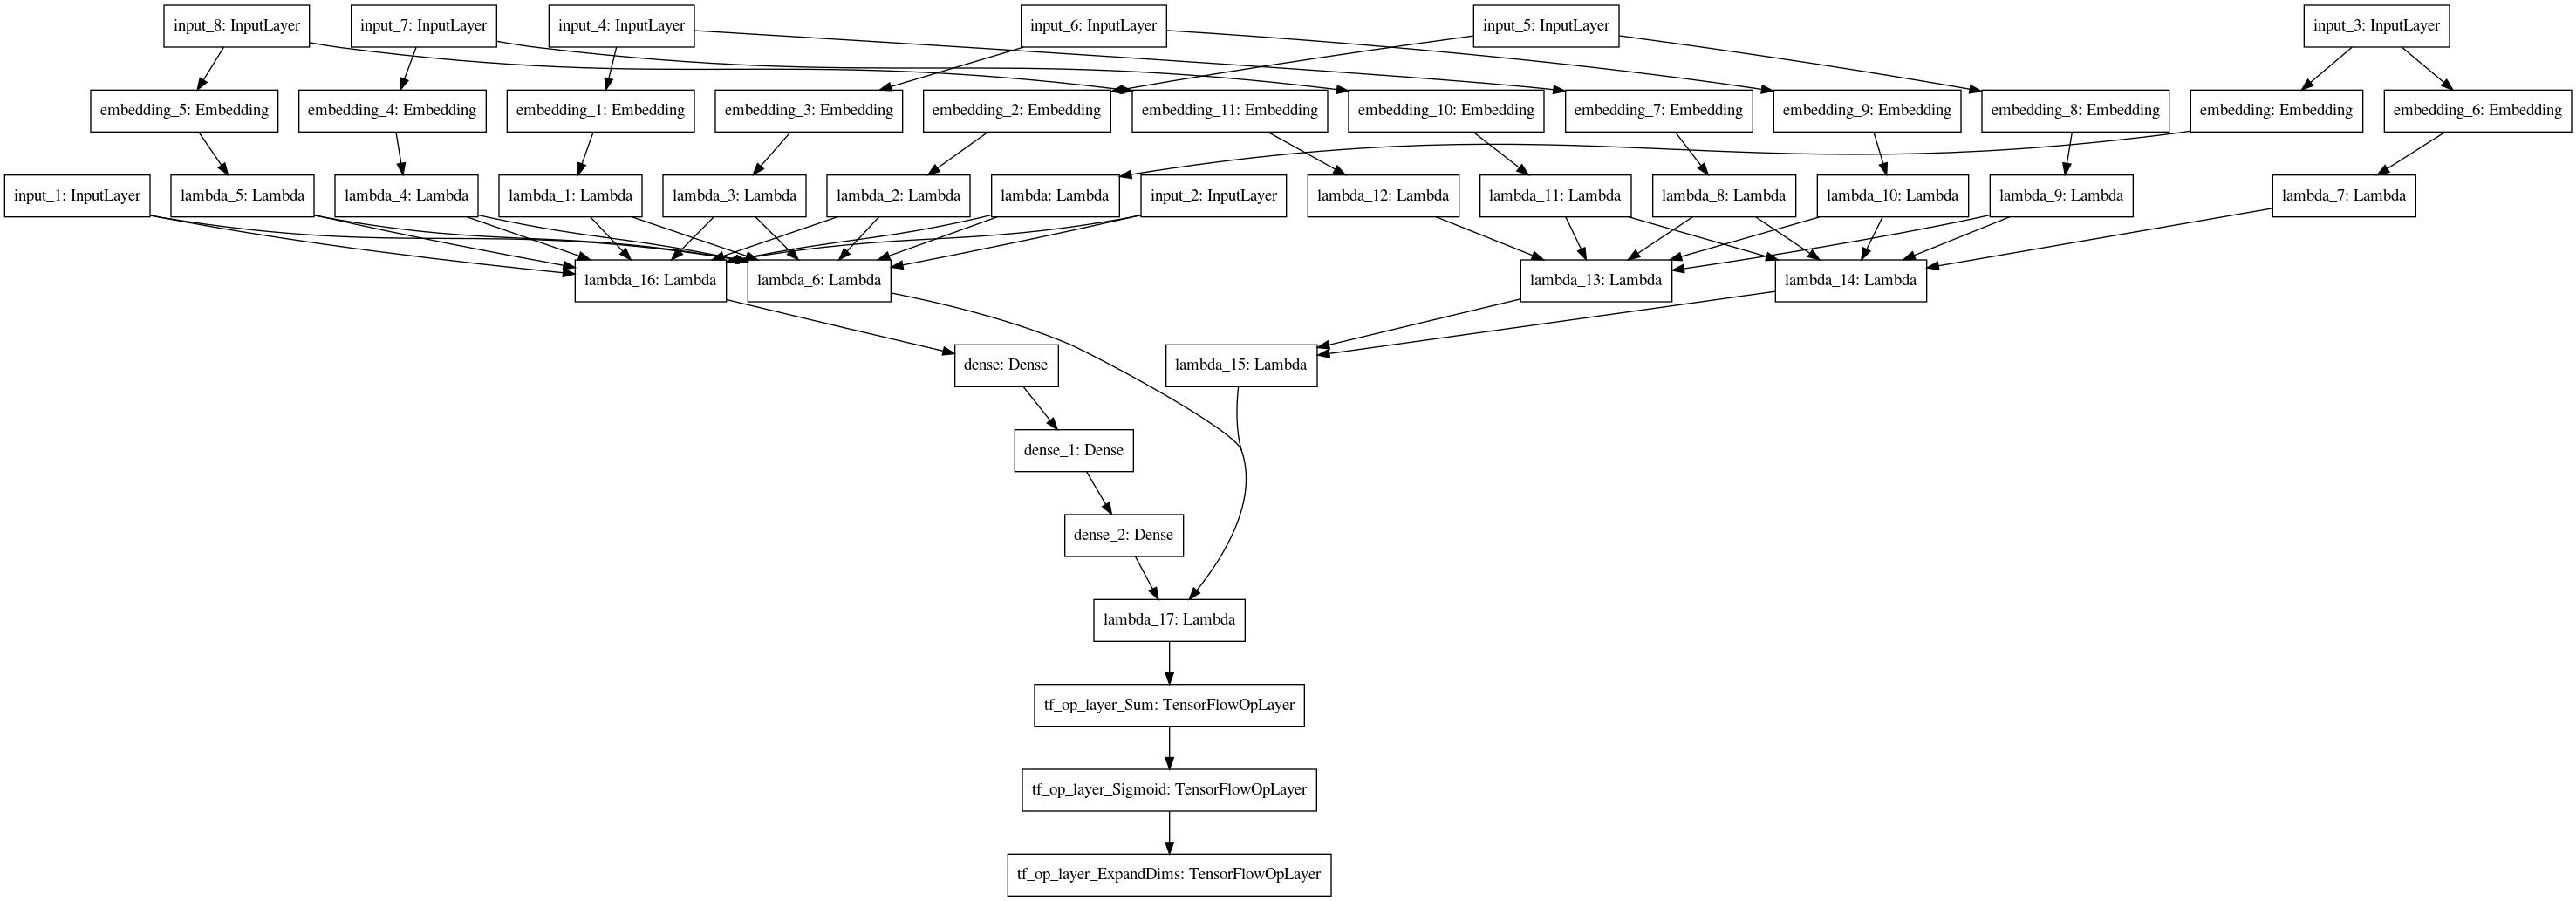

In [25]:
model = tf.keras.models.Model(inputs=inputs, outputs=logit)
tf.keras.utils.plot_model(model)

In [26]:
model.compile(loss='binary_crossentropy', 
              optimizer='adam',
              metrics=['binary_crossentropy'])

In [27]:
plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                               factor=0.1,
                                               patience=6,
                                               mode='min',
                                               verbose =1)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                 mode='min', 
                                                 patience=10,
                                                 verbose=1)

check_point = tf.keras.callbacks.ModelCheckpoint(filepath='fold_h5',
                                   monitor='val_loss',
                                   verbose=1, 
                                   mode = 'min', 
                                   save_best_only = True)

callbacks = [plateau,early_stopping,check_point]

In [28]:

valid = pd.DataFrame()
for i in range(10):
    last_records = train.drop_duplicates('user_id',keep='last')#取出每个user最后一条记录
    map__last_records__user_row = dict(zip(last_records['user_id'],last_records['row_id']))#做一个取出的user到取出的记录的行索引的字典
    train['filter_row'] = train['user_id'].map(map__last_records__user_row)#每个user新添加一个该user被拿走的最后一条的row——id的记录
    train = train[train['row_id']<train['filter_row']]#对行保留没被拿走的作为训练集
    
    valid = valid.append(last_records)
    print(len(valid))
    

3824
7646
11466
15285
19104
22923
26742
30549
34355
38159


In [29]:

features_columns = ['timestamp','prior_question_elapsed_time',\
                    'user_id','content_id',\
                    'task_container_id','prior_question_had_explanation',\
                    'bundle_id','part']#这些是要训练的
X_valid, y_valid = [valid[columns].values for columns in features_columns], valid['answered_correctly'].values#怎么理解这一句
#这是for分别取出了每一列 然后放在一个list里【】 但每个列是ndarray
X_train, y_train = [train[columns].values for columns in features_columns], train['answered_correctly'].values

In [30]:
print(type(X_train))#.values方法拿出来的是ndarray
print(type(X_train[0]))
print(type(valid))
print(type(valid['row_id']))
print(X_train[0].shape)
print(y_train.shape)
print(X_valid[0].shape)

<class 'list'>
<class 'numpy.ndarray'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
(176200,)
(176200,)
(38159,)


In [33]:
model.fit(X_train,y_train,
          epochs= 50, 
          batch_size = 512*500*2,
          verbose= 1,
          shuffle=True,
          validation_data=(X_valid,y_valid), 
          callbacks = callbacks)

Train on 176200 samples, validate on 38159 samples
Epoch 1/50

Epoch 00001: val_loss improved from 0.69382 to 0.69220, saving model to fold_h5
INFO:tensorflow:Assets written to: fold_h5/assets
176200/176200 [==============================] - 2s 9us/sample - loss: 0.6643 - binary_crossentropy: 0.6643 - val_loss: 0.6922 - val_binary_crossentropy: 0.6922
Epoch 2/50

Epoch 00002: val_loss improved from 0.69220 to 0.69045, saving model to fold_h5
INFO:tensorflow:Assets written to: fold_h5/assets
176200/176200 [==============================] - 2s 9us/sample - loss: 0.6626 - binary_crossentropy: 0.6626 - val_loss: 0.6905 - val_binary_crossentropy: 0.6905
Epoch 3/50

Epoch 00003: val_loss improved from 0.69045 to 0.68886, saving model to fold_h5
INFO:tensorflow:Assets written to: fold_h5/assets
176200/176200 [==============================] - 2s 9us/sample - loss: 0.6609 - binary_crossentropy: 0.6609 - val_loss: 0.6889 - val_binary_crossentropy: 0.6889
Epoch 4/50

Epoch 00004: val_loss improv

Epoch 28/50

Epoch 00028: val_loss did not improve from 0.66674
176200/176200 [==============================] - 0s 0us/sample - loss: 0.6023 - binary_crossentropy: 0.6023 - val_loss: 0.6668 - val_binary_crossentropy: 0.6668
Epoch 29/50

Epoch 00029: val_loss did not improve from 0.66674
176200/176200 [==============================] - 0s 0us/sample - loss: 0.6000 - binary_crossentropy: 0.6000 - val_loss: 0.6668 - val_binary_crossentropy: 0.6668
Epoch 30/50

Epoch 00030: val_loss improved from 0.66674 to 0.66632, saving model to fold_h5
INFO:tensorflow:Assets written to: fold_h5/assets
176200/176200 [==============================] - 2s 9us/sample - loss: 0.5976 - binary_crossentropy: 0.5976 - val_loss: 0.6663 - val_binary_crossentropy: 0.6663
Epoch 31/50

Epoch 00031: val_loss improved from 0.66632 to 0.66567, saving model to fold_h5
INFO:tensorflow:Assets written to: fold_h5/assets
176200/176200 [==============================] - 2s 9us/sample - loss: 0.5953 - binary_crossentropy: 0.

In [34]:
y_valid_proba = model.predict(X_valid,verbose=0,batch_size = 512)
auc = roc_auc_score(y_valid,y_valid_proba)
print(auc)

0.6871395045232996
